In [184]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
%matplotlib inline

In [185]:
def _answer_cleaning(sequence):
    answer = [s for s in re.findall(r'-?\d+\.?\d*', sequence.replace(",", ""))]
    if len(answer) == 0:
        return -np.inf
    return float(answer[-1][:-1] if answer[-1].endswith(".") else answer[-1])

def get_answer_distribution(sampled_sequences):
    answers = [_answer_cleaning(sequence) for sequence in sampled_sequences]
    if len(answers) == 0:
        return []
    answers, answer_counts = np.unique(answers, return_counts=True)
    distribution = list(zip([str(answer) for answer in answers], [answer_count/len(sampled_sequences) for answer_count in answer_counts]))
    return sorted(distribution, key=lambda x: x[1], reverse=True)

In [186]:
MODELS_INFO = {
    'gpt2-large': {
        'recurring': 'recurring__gsm8k__gpt2-large__output.json',
        'greedy': 'greedy__gsm8k__gpt2-large__output.json',
        'baseline': 'baseline__gsm8k__gpt2-large__output.json',
    },
    'gemma-2b': {
        'recurring': 'recurring__gsm8k__gemma-2b__output.json',
        'greedy': 'greedy__gsm8k__gemma-2b__output.json',
        'baseline': 'baseline__gsm8k__gemma-2b__output.json',
    },
    'gemma-7b': {
        'recurring':'recurring__gsm8k__gemma-7b__output.json',
        'greedy': 'greedy__gsm8k__gemma-7b__output.json',
        'baseline': 'baseline__gsm8k__gemma-7b__output.json',
    },
}

METHODS = ['recurring', 'baseline']

MAJORITY_THRESHOLDS = [0.3,0.5,0.7,0.9]

RECURRING_TIMESTEPS = 5

In [187]:
def conv_float(x):
    return float(x.replace(',', '')) if len(x) > 0 else float('-inf')

def parse_output_for_consistency(output, method):
    consitency_data = {}
    for inst in output:
        answer_distribution = get_answer_distribution(inst['generated_sequences'][:24]) if method != 'recurring' else inst['answer_distribution']
        answer_distribution = answer_distribution if method != 'recurring' else answer_distribution[2 if len(answer_distribution) > 2 else -1]
        correct = int(conv_float(answer_distribution[0][0]) == conv_float(inst['ground_truth_answer' if method != 'recurring' else 'ground_truth_answers']))
        consit = str(answer_distribution[0][1])
        if consit not in consitency_data:
            consitency_data[consit] = {
                'correct': correct,
                'total': 1
            }
        else:
            consitency_data[consit]['correct'] += correct
            consitency_data[consit]['total'] += 1
    
    final_consitency_data = {key: consitency_data[key]['correct']/consitency_data[key]['total'] for key in consitency_data}
    
    return final_consitency_data

def get_consistency_vs_accuracy(model_name, method):
    file = os.path.join('../../results/', MODELS_INFO[model_name][method])
    output = json.load(open(file, 'r'))
    
    consitency_data = parse_output_for_consistency(output, method)
    
    return consitency_data

In [188]:
plot_df = pd.DataFrame(columns=['Model', 'Method', 'consistency', 'accuracy'])

for model_name in MODELS_INFO:
    for method in METHODS:
        print(f'Processing {model_name} - {method}')
        consitency_data = get_consistency_vs_accuracy(model_name, method)
        for key in consitency_data:
            plot_df = pd.concat([plot_df, pd.DataFrame({
                'Model': model_name,
                'Method': "RSC (Our Approch)" if method == 'recurring' else "Self-Consistency",
                'consistency': float(key),
                'accuracy': [consitency_data[key]]
            })], ignore_index=True)

Processing gpt2-large - recurring


C:\Users\AADAM\AppData\Local\Temp\ipykernel_47288\1052950820.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, pd.DataFrame({


Processing gpt2-large - baseline
Processing gemma-2b - recurring
Processing gemma-2b - baseline
Processing gemma-7b - recurring
Processing gemma-7b - baseline


In [189]:
plot_df.head(20)

,Model,Method,consistency,accuracy
0,gpt2-large,RSC (Our Approch),0.625000,0.016537
1,gpt2-large,RSC (Our Approch),0.500000,0.018600
2,gpt2-large,RSC (Our Approch),0.375000,0.016680
3,gpt2-large,RSC (Our Approch),0.125000,0.012658
4,gpt2-large,RSC (Our Approch),0.250000,0.019883
5,gpt2-large,RSC (Our Approch),1.000000,0.030189
6,gpt2-large,RSC (Our Approch),0.750000,0.006276
7,gpt2-large,RSC (Our Approch),0.875000,0.036364
8,gpt2-large,Self-Consistency,0.333333,0.019355
9,gpt2-large,Self-Consistency,0.166667,0.020690


[]

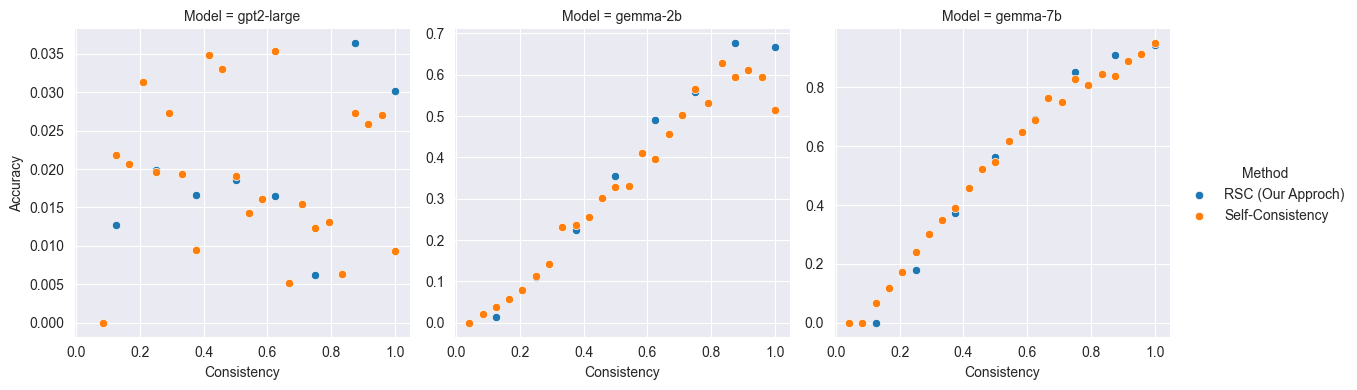

In [191]:
sns.set_style("darkgrid")
g = sns.FacetGrid(plot_df, col="Model", hue="Method", sharey=False, height=4)
g.map(sns.scatterplot,'consistency','accuracy')
g.axes[0,0].set_xlabel('Consistency')
g.axes[0,1].set_xlabel('Consistency')
g.axes[0,2].set_xlabel('Consistency')
g.axes[0,0].set_ylabel('Accuracy')
g.add_legend()
plt.plot()